# Cats Vs Dogs

Image Classifier which classifies cats and dogs

### Importing Libraries

Libraries used for this exercise are:
1. os for creating directories and folders
2. zipfile for extracting the data from the zip file
3. numpy for creating and modifing arrays
4. pandas for dataframes
4. matplotlib for ploting and visualizing the data
5. tensorflow for implementing the CNN

In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Loading the Data

You can download the data by running this script

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-07-14 15:53:03--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 66.102.1.128, 64.233.167.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   121MB/s    in 0.5s    

2020-07-14 15:53:03 (121 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



The file is then unziped and seperated into different folders which contain the photos for our problem.

Tensorflow's Image Generator will name the data according to the folder names.

For eg: we have our dataset split into parts test and validation and each folder contains two sub-folder namely cats and dogs. All the images that are in the `'/training/cats/'` folder will be considered as the training data for cats while `'/training/dogs/'` folder will be considered as the training data for dogs.

In [3]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

### Creating the Neural Network

The model will first take an image and try multiple convolutions on it using the `Conv2D` layer.

A (3,3) convolution multiples the pixels of the image by a 3 by 3 matrix. This matrix consists of values according to which certainfeatures of the image are highlighted or removed. This works much like applying a filter on the image.
An image of 150 by 150 pixles when passed through a 3 by 3 convolution gets reduced to a 148 by 148 pixel image as the filter cannot be applies to the sides of the image as the don't have all the neighbouring pixels.

The image is then passed through a `MaxPooling2D` layer. If an input of (2,2) is given then the layer keeps the largest value of the 4 neighbouring pixles and deletes the rest. Thus reducing the amount of information that is needed to be processed making our Network run faster

The Image is the flattened and passed through the Dense layer. (More information on these layers and activations is given in the Fashoin MNIST problem)

In [4]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

By calling the summary method we can see how the data is tranformed as it passes through the model

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

We then compile the model.

Here we use the `binary_crossentropy` loss function as there are only two outputs.

In [6]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

### Image Generators

To auto label the images in there folders we make use of the `ImageDataGenerator` by Tensorflow. We first rescale the values of all the pixels to be from 0 to 1 instead of 0 to 255 using the `rescale` attribute.
The `target_size` and `batch_size` of the images are then decided by calling the `flow_from_directory`. The `class_mode` is used to tell if it is a binary or multiclass classification.

In [7]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Fitting the Model

Here we call the `fit` method. We pass the training generator as the first parameter and decide the number of epochs the model should be run on. The `validation_data` attribute takes in the validation generator.

I will be running a 100 epochs so that I can plot the data

In [9]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=1)

Epoch 1/100
100/100 [==============================] - 11s 113ms/step - loss: 0.6717 - accuracy: 0.5720 - val_loss: 0.6477 - val_accuracy: 0.6520
Epoch 2/100
100/100 [==============================] - 11s 109ms/step - loss: 0.6354 - accuracy: 0.6410 - val_loss: 0.6066 - val_accuracy: 0.6920
Epoch 3/100
100/100 [==============================] - 11s 109ms/step - loss: 0.5877 - accuracy: 0.6840 - val_loss: 0.5812 - val_accuracy: 0.7000
Epoch 4/100
100/100 [==============================] - 11s 107ms/step - loss: 0.5545 - accuracy: 0.7200 - val_loss: 0.5722 - val_accuracy: 0.7060
Epoch 5/100
100/100 [==============================] - 11s 110ms/step - loss: 0.5296 - accuracy: 0.7340 - val_loss: 0.5476 - val_accuracy: 0.7240
Epoch 6/100
100/100 [==============================] - 11s 110ms/step - loss: 0.5036 - accuracy: 0.7545 - val_loss: 0.5518 - val_accuracy: 0.7180
Epoch 7/100
100/100 [==============================] - 11s 110ms/step - loss: 0.4819 - accuracy: 0.7750 - val_loss: 0.5397 -

### Visualizing the data

Accuracy and Loss plots for comparing the training accuracy and validation accuracy and training loss and validation loss

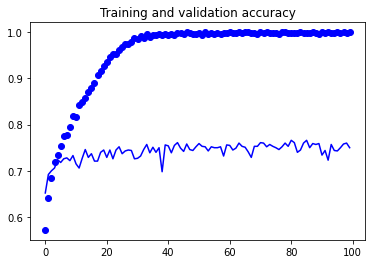

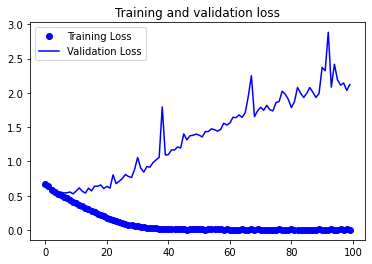

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Here you can view how an image looks as it passes through all the convolution and pooling layers

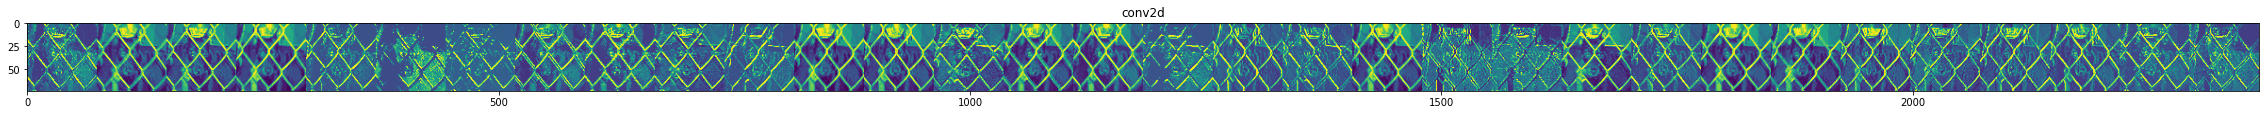

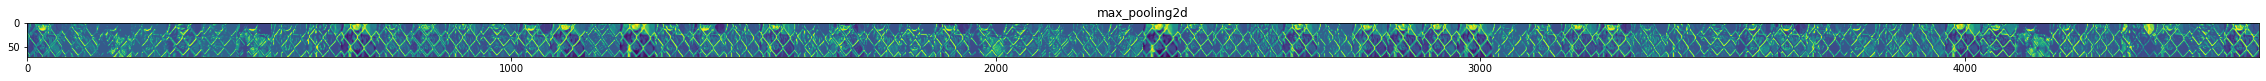

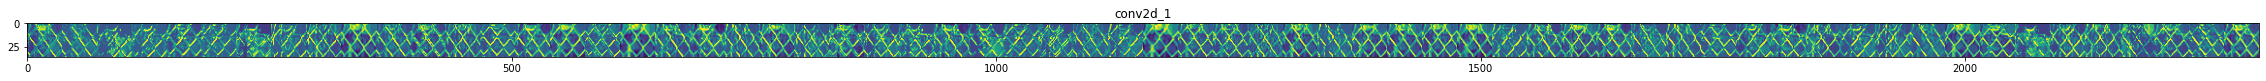

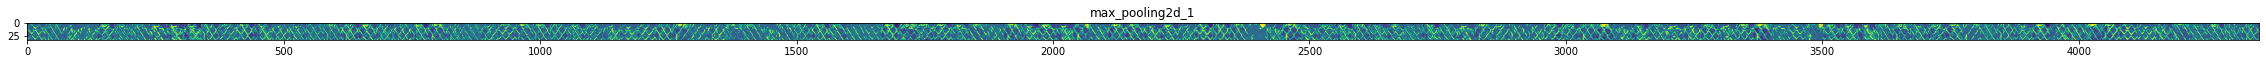

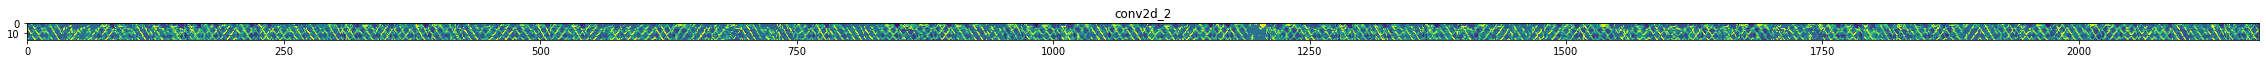

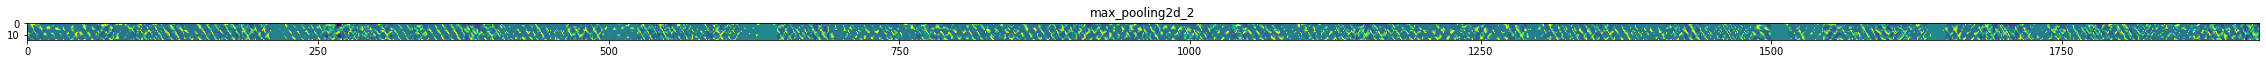

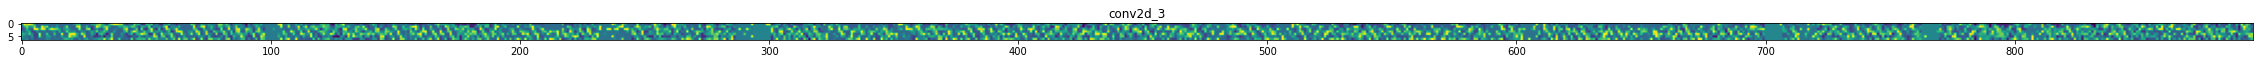

In [16]:
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * 2 *n_features, 2 * scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 